# Note
- check-in/out: https://github.com/shinjuku-mokumoku/shinjuku-mokumoku/blob/master/meetups/16/komo-fr.md
- repo: (TODO)
- nbviewer: (TODO)

In [2]:
%%html
<style>
@charset ‘utf-8’;

@import url(‘https://fonts.googleapis.com/css?family=Fira+Mono’);

@font-face {
  font-family: 'Fira Mono';
}
.CodeMirror pre, .output pre {
    font-size: 15px;
    line-height: 110%;
    font-family: Monaco, monospace;
}
</style>

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Fitbitから脈拍データを取得する

## 脈拍データってどんなの？
画像はfitbitアプリの画面です。

### 割と普通の日
<img src="https://user-images.githubusercontent.com/31801148/46568468-4b3bb080-c980-11e8-8e3b-2ea80137792d.PNG" width=500>


### なんかテンパってた日
<img src="https://user-images.githubusercontent.com/31801148/46568465-4aa31a00-c980-11e8-80f6-34f48d4e1913.PNG" width=500>


### 体調くずして１日中寝てた日
- ご飯食べるために立ち上がったときだけ心拍数が上がってる
<img src="https://user-images.githubusercontent.com/31801148/46568466-4b3bb080-c980-11e8-85a0-aae584aa805a.PNG" width=500>

### 問題の日
<img src="https://user-images.githubusercontent.com/31801148/46568467-4b3bb080-c980-11e8-8244-f6845c61ea37.PNG" width=500>

# Pythonでデータを見ていく

In [154]:
import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import fitbit

# 認証がらみの設定を格納しているモジュール (非公開)
from secret.settings import FitbitSetting

%matplotlib inline

# Settings

In [139]:
HEART_ZONE2COLOR_MAP = {'Out of Range': '#58BE89',
                        'Fat Burn':'#FBA848',
                        'Cardio':'#F27398',
                        'Peak':'#FF4000',
                        'No Data':'#363947',
                        'Others': 'gray'}  # TODO: Othersの素性調査と色の検討


# Function

In [68]:
def make_datetime_base_df(start_hour: int = 0,
                          end_hour: int = 24,
                          min_unit: int=1) -> pd.DataFrame:
    """
    start_hourからend_hourまでの分刻みの値を持つデータフレームを作成する
    例) index | time
        0     | 00:00:00
        1     | 00:01:00
        ...
        1439  |23:59:00
        
    
    # TODO: 関数の役割、名前、説明を見直す
    # TODO: 1sec刻みのデータへの対応
    
    :params: start_hour: 開始時刻
    :params: start_hour: int
    :params: end_hour: 終了時刻
    :params: end_hour: int
    :params min_unit: 分刻みの単位。
    :params min_unit: int
    :return time列を持つpandasのデータフレーム
    :rtype pd.DataFrame
    """
    time_index = []
    
    for hour in range(start_hour, end_hour):
        for minute in range(0, 60, min_unit):
            time_index.append(str(dt.time(hour, minute, 0)))
    datetime_base_df = pd.DataFrame(time_index).rename(columns={0: 'time'})
    
    return datetime_base_df    

In [107]:
def convert_dict2df(heart_dict: dict) -> pd.DataFrame:
    """fitbitの脈拍データをdictからpandasのDataFrameに変換する      
    :param heart_dict: dict形式の脈拍データ
    :param heart_dict: dict
    :return: pandasのデータフレーム型の脈拍データ
    index(日時), time(時刻), value(脈拍値)
    :rtype: pd.DataFrame
    """
    heart_data_intraday = heart_dict["activities-heart-intraday"]["dataset"]
    heart_df = pd.DataFrame.from_dict(heart_data_intraday)

    date = heart_dict['activities-heart'][0]['dateTime']
    
    '''
    if heart_df.shape[0] == 60*24:
        # 1分刻みの脈拍データ
        min_unit = 1
    elif heart_df.shape[0] == 60*24/15:
        # 15分刻みの脈拍データ
        min_unit = 15
    else:
        # TODO: 1sec刻みのデータへの対応
        message = "This data format is not supported. (The dataframe's shape is {}.)"
        raise ValueError(message.format(heart_df.shape))
    '''
    
    time_base_df = make_datetime_base_df()
    heart_df = pd.merge(time_base_df, heart_df, on='time', how='left')
    heart_df.index = pd.to_datetime([date + " " + t for t in heart_df.time])
    heart_df.time = heart_df.time.apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S' ).time())

    return heart_df

In [141]:
def categorize_zone(value: float, heart_rate_zones_range: dict) -> str:
    """指定した脈拍値がどのゾーンに当てはまるのかカテゴライズする
    :param value: 脈拍値
    :param value: float
    :param heart_rate_zones_range: 各ゾーンの範囲（Cardio, Fat Burn, Out of Range, Peak）
    :param dict: 
    :return: ゾーン（Cardio, Fat Burn, Out of Range, Peak, Others, No Data）
    :rtype str
    """

    if value != value or value == 0:
        return 'No Data'

    zone = 'Unknown'

    # TODO: 他のやり方でも書けそうな気がする
    zone_name_list = ['Peak', 'Cardio', 'Fat Burn', 'Out of Range']
    for zone_name in zone_name_list:
        min_value = heart_rate_zones_range[zone_name]['min_value']
        max_value = heart_rate_zones_range[zone_name]['max_value']
        if min_value <= value < max_value:
            zone = zone_name
            break
    else:
        zone = 'Others'

    return zone

In [109]:
def get_heart_rate_zones_range(heart_dict: dict) -> dict:
    """脈拍の各ゾーンの範囲を取得する(Cardio, Fat Burn, Out of Range, Peak)
    :param heart_dict: 脈拍データ
    :param heart_dict: dict
    :return: 各ゾーンの範囲（Cardio, Fat Burn, Out of Range, Peak）
    :rtype dict
    """
    
    # 元のデータは、dictが入ったリスト形式で格納されている
    # 例) [{'caloriesOut': 989.0036,'max': 94, 'min': 30, 'minutes': 904, 'name': 'Out of Range'},
    # ... {'caloriesOut': 0, 'max': 220, 'min': 160, 'minutes': 0, 'name': 'Peak'}]
    rate_zones = heart_dict["activities-heart"][0]['value']['heartRateZones']
    
    # name値(Caridio, Fat Burnなど)をキーとするdictに変換する
    # 例) {'Cardio': {'max_value': 160, 'min_value': 132},
    # ...  'Peak': {'max_value': 220, 'min_value': 160}}
    rate_zones_range = {}
    for rate_zone in rate_zones:
        max_value = rate_zone['max']
        min_value = rate_zone['min']
        name = rate_zone['name']
        rate_zones_range[name] = dict(max_value=max_value, min_value=min_value)
        
    return rate_zones_range

# Get Data

In [180]:
date = '2018-09-17'

# 認証
authd_client = fitbit.Fitbit(FitbitSetting.CLIENT_ID,
                             FitbitSetting.CLIENT_SECRET,
                             access_token=FitbitSetting.ACCESS_TOKEN,
                             refresh_token=FitbitSetting.REFRESH_TOKEN)
# 脈拍データを取得
heart_data = authd_client.intraday_time_series('activities/heart',
                                               date,
                                               detail_level='1min')  # '1sec', '1min', or '15min'

In [181]:
# データの形の確認
heart_data['activities-heart-intraday']

{'dataset': [{'time': '00:00:00', 'value': 93},
  {'time': '00:01:00', 'value': 90},
  {'time': '00:02:00', 'value': 97},
  {'time': '00:03:00', 'value': 98},
  {'time': '00:04:00', 'value': 98},
  {'time': '00:05:00', 'value': 98},
  {'time': '00:06:00', 'value': 93},
  {'time': '00:07:00', 'value': 94},
  {'time': '00:08:00', 'value': 96},
  {'time': '00:09:00', 'value': 95},
  {'time': '00:10:00', 'value': 100},
  {'time': '00:11:00', 'value': 109},
  {'time': '00:12:00', 'value': 107},
  {'time': '00:13:00', 'value': 92},
  {'time': '00:14:00', 'value': 97},
  {'time': '00:15:00', 'value': 95},
  {'time': '00:16:00', 'value': 92},
  {'time': '00:17:00', 'value': 88},
  {'time': '00:18:00', 'value': 94},
  {'time': '00:19:00', 'value': 89},
  {'time': '00:20:00', 'value': 89},
  {'time': '00:21:00', 'value': 88},
  {'time': '00:22:00', 'value': 89},
  {'time': '00:23:00', 'value': 90},
  {'time': '00:24:00', 'value': 91},
  {'time': '00:25:00', 'value': 93},
  {'time': '00:26:00', '

In [200]:
# pandasに変換
df = convert_dict2df(heart_data)
df.head(5)

,time,value
2018-09-17 00:00:00,00:00:00,93.0
2018-09-17 00:01:00,00:01:00,90.0
2018-09-17 00:02:00,00:02:00,97.0
2018-09-17 00:03:00,00:03:00,98.0
2018-09-17 00:04:00,00:04:00,98.0


In [201]:
# 心拍ゾーンの割当て
zone_range_dict = get_heart_rate_zones_range(heart_data)
df['zone'] = df['value'].apply(lambda x: categorize_zone(x, zone_range_dict))
df['color'] = df.zone.apply(lambda x: HEART_ZONE2COLOR_MAP[x])

# df = df.reset_index().rename(columns={'index': 'datetime'})
# df['value'] = df.value.fillna(0)

# Visualize

In [202]:
target_date_converted = dt.datetime.strptime(date, '%Y-%m-%d')
x_start = dt.datetime(target_date_converted.year,
                      target_date_converted.month,
                      target_date_converted.day, 0, 0, 0)
x_end = x_start + dt.timedelta(days = 1)
x_start, x_end

(datetime.datetime(2018, 9, 17, 0, 0), datetime.datetime(2018, 9, 18, 0, 0))

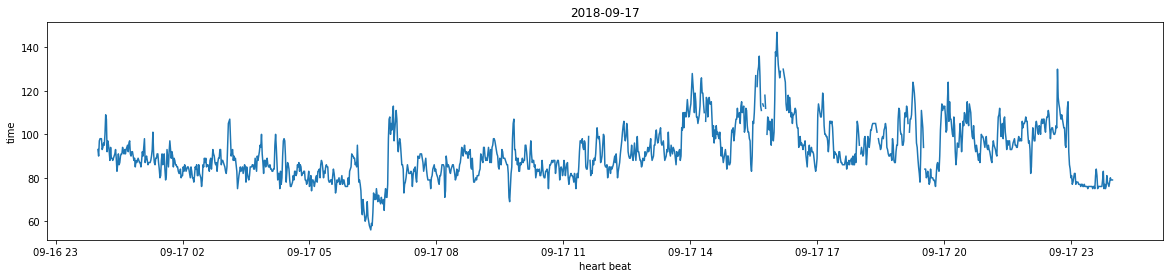

In [203]:
# まずは基本から
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(df.index, df.value)
ax.set_title(date)
ax.set_xlabel('heart beat')
ax.set_ylabel('time')
plt.show()

## 諸々の表示設定

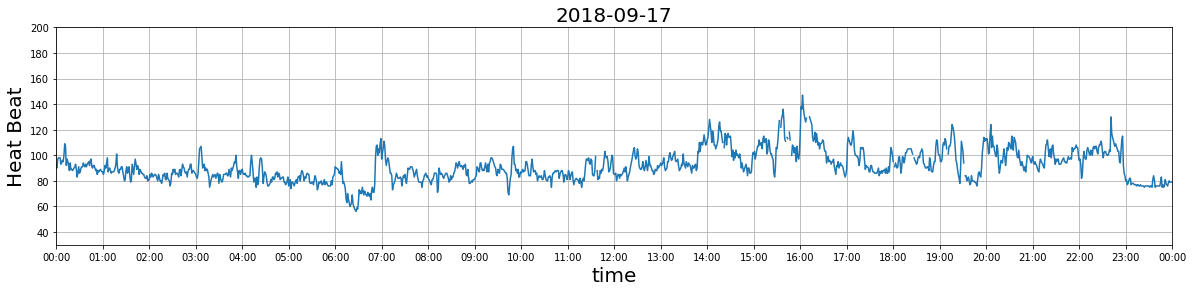

In [204]:
fig, ax = plt.subplots(figsize=(20, 4))

# グリッド線を表示
ax.grid(True)

# x軸の設定
ax.plot(df.index, df.value)
ax.set_xlim(xmin=x_start, xmax=x_end)
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)

locator = mdates.HourLocator(interval=1)
ax.xaxis.set_major_locator(locator)

# y軸の設定
ax.set_ylim(ymin=30, ymax=200)

ax.set_title(date, size=20)
ax.set_xlabel('time', size=20)
ax.set_ylabel('Heat Beat', size=20)
plt.show()

In [175]:
# Zoneごとに背景色を変える